In [88]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
%matplotlib inline
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

sns.set_palette(sns.color_palette("Paired"))

In [2]:
print("python version is: ", sys.version)
print("pandas version is: ", pd.__version__)
print("numpy version is: ", np.__version__)
print("seaborn version is: ", sns.__version__)

python version is:  3.6.3 |Anaconda custom (64-bit)| (default, Oct 13 2017, 12:02:49) 
[GCC 7.2.0]
pandas version is:  0.22.0
numpy version is:  1.14.0
seaborn version is:  0.8.0


In [3]:
df = pd.read_csv("all_earthquakes.csv", parse_dates=['time'])
df.head()

/home/fibinse/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (7,12,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,depth,depthError,dmin,gap,horizontalError,id,latitude,locationSource,longitude,mag,magError,magNst,magSource,magType,source_network,num_of_nw_stations,place,rms,status,time,type,updated,country,year
0,28.900,0.30,NaN,NaN,0.20,ak11715681,61.332500,ak,-147.998300,1.20,NaN,NaN,ak,ml,ak,NaN,"59km ESE of Butte, Alaska",0.45,reviewed,2015-09-19 23:59:29.000,earthquake,2015-09-24T23:57:41.501Z,United States of America,2015
1,16.360,0.88,0.05199,46.0,0.36,ci37245567,34.392667,ci,-118.980833,1.36,0.052,15.0,ci,ml,ci,38.0,"6km W of Fillmore, CA",0.29,reviewed,2015-09-19 23:57:55.660,earthquake,2016-03-11T06:37:02.297Z,United States of America,2015
2,12.300,0.40,NaN,NaN,0.30,ak11715669,61.643900,ak,-151.352000,0.80,NaN,NaN,ak,ml,ak,NaN,"70km W of Willow, Alaska",0.51,reviewed,2015-09-19 23:55:06.000,earthquake,2015-09-28T17:09:49.203Z,United States of America,2015
3,7.087,0.45,0.07658,38.0,0.17,nc72523765,39.235000,nc,-123.209333,1.83,0.145,27.0,nc,md,nc,29.0,"3km S of Redwood Valley, California",0.06,reviewed,2015-09-19 23:35:53.740,earthquake,2017-02-08T11:43:43.779Z,United States of America,2015
4,10.920,0.52,0.05772,96.0,0.30,ci37245559,33.495667,ci,-116.486333,0.96,0.166,26.0,ci,ml,ci,31.0,"19km ESE of Anza, CA",0.20,reviewed,2015-09-19 23:33:17.180,earthquake,2016-03-11T02:57:36.685Z,United States of America,2015


`time` - Time when the event occurred. Times are reported in milliseconds since the epoch ( 1970-01-01T00:00:00.000Z), and do not include leap seconds. In certain output formats, the date is formatted for readability.

`latitude` - Decimal degrees latitude. Negative values for southern latitudes

`longitude` - Decimal degrees longitude. Negative values for western longitudes.

`depth` - Depth of the event in kilometers.

`mag` - magnitude of earthquake

`magType` - The method or algorithm used to calculate the preferred magnitude for the event.

`nst` - The total number of Number of seismic stations which reported P- and S-arrival times for this earthquake.

`gap` - gap between azimuthally adjacent stations (in degrees). In general, the smaller this number, the more reliable is the calculated horizontal position of the earthquake.

`dmin` - Horizontal distance from the epicenter to the nearest station (in degrees). 1 degree is approximately 111.2 kilometers. In general, the smaller this number, the more reliable is the calculated depth of the earthquake.

`rms` - This parameter provides a measure of the fit of the observed arrival times to the predicted arrival times for this location. Smaller numbers reflect a better fit of the data.

`net` - Identifies the network considered to be the preferred source of information for this event.

`id` - A code consisting of source, type, code, updateTime. Eg: us20002wt7

`updated` - Time when the event was most recently updated.

`place` - Textual description of named geographic region near to the event

`type` - Type of seismic event`

### Takeaways

- earthquake epicenters are estimated by a form of signal triangulation. https://www.youtube.com/watch?v=dx4OqT0PYnU
- The more stations measure this, more accurate the accuracy of an earthquake's coordinates and its depth would be.
`nst` captures this information.

#### Cleaning up the country names

In [4]:
from config import *
if 'country' not in df:
    # source - https://stackoverflow.com/a/46589405/170005
    from shapely.geometry import mapping, shape
    from shapely.prepared import prep
    from shapely.geometry import Point
    import requests


    data = requests.get("https://raw.githubusercontent.com/datasets/geo-countries/master/data/countries.geojson").json()

    countries = {}
    for feature in data["features"]:
        geom = feature["geometry"]
        country = feature["properties"]["ADMIN"]
        countries[country] = prep(shape(geom))

    print(len(countries))

    def get_country(lon, lat):
        point = Point(lon, lat)
        for country, geom in countries.items():
            if geom.contains(point):
                return country

        return "unknown"


    print("This takes a long time to execute. You've been warned.")
    df.loc[:, 'country'] = df.apply(lambda v: get_country(v['longitude'], v['latitude']), axis=1)
    
    mask = (df.country == 'unknown')
    def extract_region(v):
        place = v.split(',')[-1].strip().capitalize()
        replacements = [
            ' region', 'North of the ', 'Southern ',
            'Offshore ', 'Off the coast of central ',
            'Off the coast of southern ', 'South of the ',
            'Off the coast of ', 'Northern', 'South '
            'West of ', ' peninsula', 'East of the ',
            'Near the coast of ', ' - reunion',
            'Southwest of ', 'South of ',
            'Near the east coast of ', 'Central ',
            'North of ', 'Southern ', 'West of ', 
            'Southeastern ', 'Northwest of the '
        ]
        for phrase in replacements:
            place = place.replace(phrase, '').strip()
        return ' '.join([p.capitalize() for p in place.split() 
                         if p not in ('of', 'the', 'in')])
    df.loc[mask, 'country'] = df.loc[mask, 'place'].fillna('').apply(extract_region)

df.loc[:, 'country'] = df.country.str.strip().replace(place_mapping).str.strip()
df.to_csv("all_earthquakes.csv", index=False, encoding='utf-8')

In [5]:
df['year'] = df.time.dt.year

There are very few seismic events before 1970, compared to after it.
Since pre-1970 seems kind of barren, we will filter it out.

In [6]:
df = df[df['year'] > 1970]

#### We see how 2013 saw almost 4 times the events than 2012.

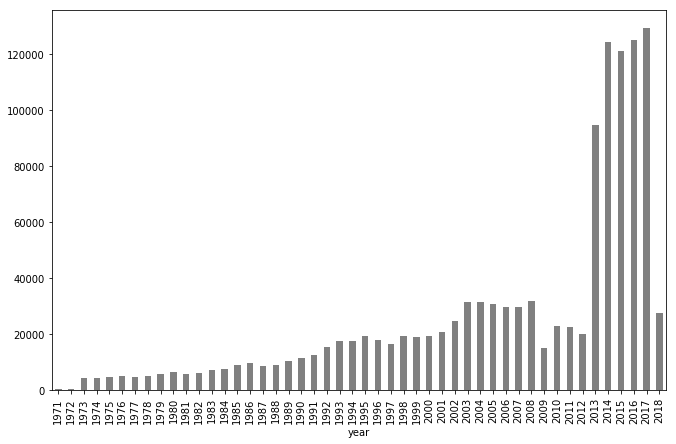

In [7]:
temp = df.groupby('year')['id'].count()
_ = temp.plot(kind='bar', figsize=(11, 7), color=['grey'])

The year-on-year percentage change in the number of seismic events may be something to interesting to look at.
    - 1973 sees a mountaineous spike. We don't know why that is. Then there is 2013.
    - 2009 saw a large decrease in the number of events. Which is weird.

<Container object of 14 artists>

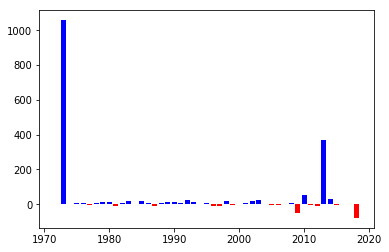

In [8]:
yoy = pd.DataFrame(temp.pct_change()*100).rename(columns={'id': 'growth'})

mask1 = yoy.growth >= 0
mask2 = yoy.growth < 0

plt.bar(yoy.index[mask1], yoy.growth[mask1], color = 'blue')
plt.bar(yoy.index[mask2], yoy.growth[mask2], color = 'red')
# plt.title('year-on-year % change in earthquake count')

Let's slice the data into country-wise time-series format.

In [9]:
temp = pd.pivot_table(df, index='year', columns='country', values='id', aggfunc='count')
temp.sum().describe()

count       437.000000
mean       2823.421053
std       29089.513430
min           1.000000
25%           7.000000
50%          54.000000
75%         635.000000
max      601596.000000
dtype: float64

Almost 75% of the countries listed (or derived by us using further mapping) in the data, have less than 648
earthquakes across the years. 

I wonder how the distribution is beyond that. Let's take a look.

In [10]:
for_pctiles = temp.sum()
for pctile in [0.75, 0.80, 0.9, .95, .97, .98, .99]:
    value = for_pctiles.quantile(pctile)
    ctry_count = for_pctiles[for_pctiles > value].shape[0]
    print('At {:,.2f} %ile, event count : {:,.0f} & {:d} countries with more events.'.format(pctile,
                                                        value,
                                                        ctry_count))

At 0.75 %ile, event count : 635 & 109 countries with more events.
At 0.80 %ile, event count : 998 & 88 countries with more events.
At 0.90 %ile, event count : 3,216 & 44 countries with more events.
At 0.95 %ile, event count : 7,696 & 22 countries with more events.
At 0.97 %ile, event count : 13,393 & 14 countries with more events.
At 0.98 %ile, event count : 16,727 & 9 countries with more events.
At 0.99 %ile, event count : 26,892 & 5 countries with more events.


Ten thousand events seems to be a good point to filter out countries at.

In [11]:
most_shaky_countries = temp.sum()[temp.sum() > 10000].index
print(most_shaky_countries.tolist())

['Canada', 'Chile', 'China', 'Fiji', 'France', 'Greece', 'Indonesia', 'Italy', 'Japan', 'Kuril Islands', 'Mexico', 'New Zealand', 'Papua New Guinea', 'Philippines', 'Puerto Rico', 'Russia', 'Tonga', 'Turkey', 'United States of America']


Among these most shaky countries, US displays some very distinct behaviour.

It seems to single-handedly contribute to the spike in the year 2013.

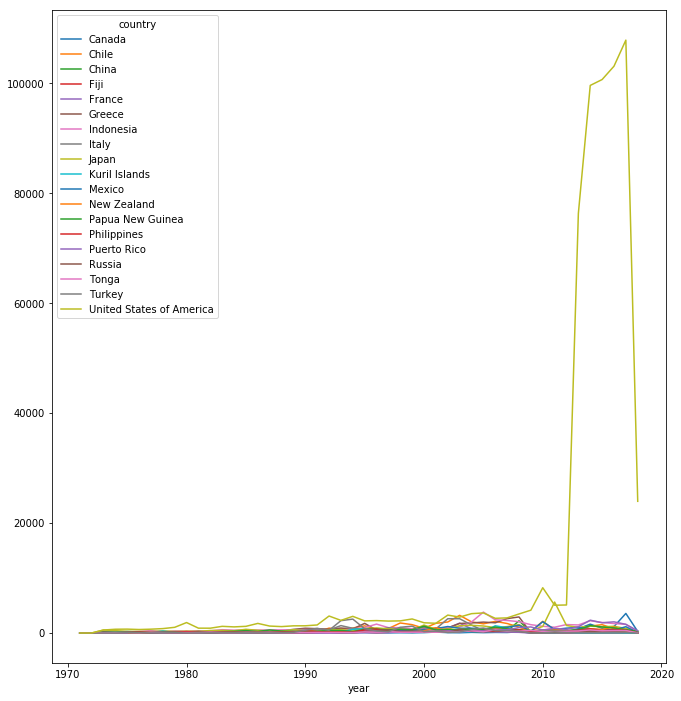

In [12]:
temp[most_shaky_countries].plot(kind='line', figsize=(11, 12))

If we were to remove US from the picture, we would certainly be able to see more trending behaviour in the subset of these countries.

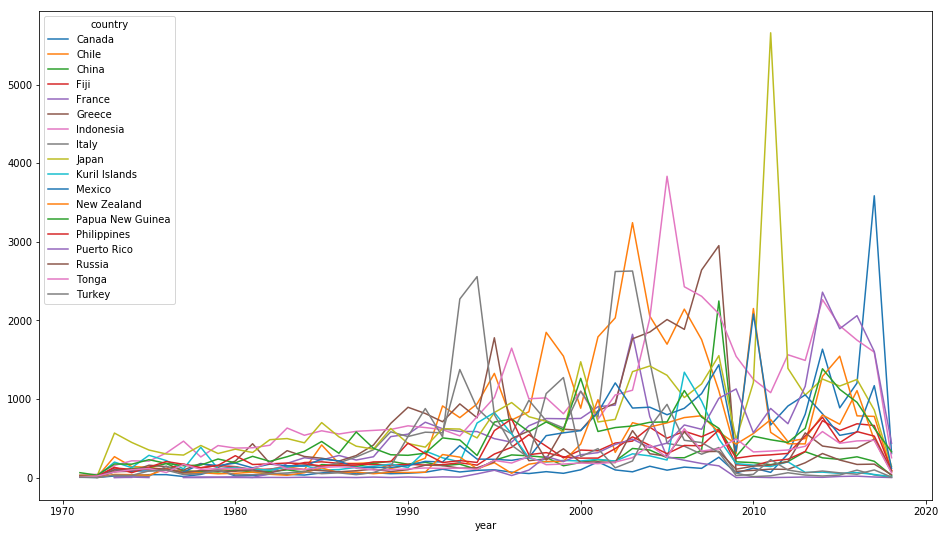

In [13]:
_ = temp[most_shaky_countries.drop('United States of America', 1)
        ].plot(kind='line', figsize=(16, 9))

#### Which years had the most major earthquakes ?

2010-2013 had the most number of greater than 5 Richter scale earthquakes.

Even though 2013 onwards the total number of earthquakes occurring had doubled in count.

1245.375


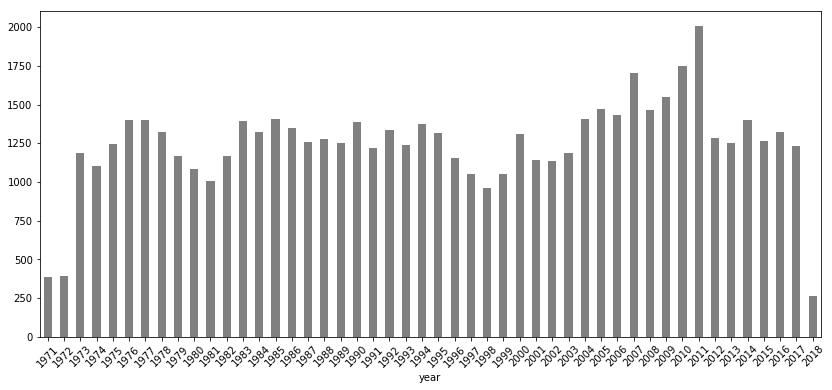

In [26]:
temp = df[df.mag > 5].groupby('year')['id'].count()
print(temp.mean())
_ = temp.plot(kind='bar', color=['grey'], figsize=(14, 6), rot=45)

#### Distribution of major events among all countries

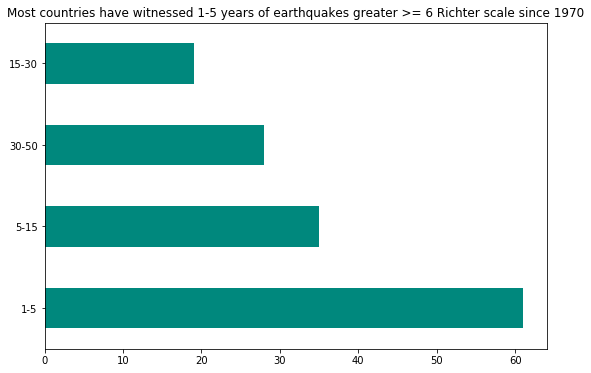

In [95]:
temp = df.pivot_table(index='year', columns='country', values='mag', aggfunc='max')
years_major_events = temp[temp >= 6].count() 
_ = pd.cut(years_major_events, bins=[1, 5, 15, 30, 50], 
       labels=['1-5', '5-15', '15-30', '30-50']
      ).value_counts().plot(kind='barh', color='#00887d',
                           title='Most countries have witnessed 1-5 years of earthquakes greater >= 6 Richter scale since 1970',
                           figsize=(9, 6))


#### Which are the worst hit countries ?

We are looking for countries with a greater than 6 Richter scale seismic event for 3-5 consecutive years.

temp_df = (temp >= 6).astype(int)
temp_df.rolling(5).apply(lambda v: v.sum()==5)